# Data Analysis on Heart Disease

## Introduction
One of the leading causes of death in the world and the leading cause in the United States, is heart disease and has been for many years. With the rate of them increasing worldwide in recent years, it is important to look at the leading causes of this disease and establish a relationship between them and its global increase. As a base for our analysis we are going to use the heart disease dataset available at Kaggle.

The dataset originates from 1988 and evaluates data from four different databases: Cleveland, Hungary, Switzerland and Long Beach V. While the dataset does have 76 distinct attributes, it only utilizes 14 of them. 

**Predictive question:**
How does the amount of cholesterol, type of heart defect, age, and sex help us predict the diagnosis of heart disease?


In [1]:
### Run this cell before continuing.

library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(ggplot2)
options(repr.matrix.max.rows = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

**Reading the Data**

First read the raw data from GitHub that we uploaded.

In [2]:
heart_disease_data <- read_csv("https://raw.githubusercontent.com/yma24ma/dsci_009_43_gp/main/heart.csv")
heart_disease_data

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
47,1,0,110,275,0,0,118,1,1.0,1,1,2,0


**Variables**

age: Age

sex: Sex

cp: Chest pain type (4 values)

trestbps: resting blood pressure

chol: serum cholestoral in mg/dl

fbs: fasting blood sugar > 120 mg/dl

restecg: resting electrocardiographic results (values 0,1,2)

thalacg: maximum heart rate achieved

exang: exercise induced angina

oldpeak: ST depression induced by exercise relative to rest

slope: the slope of the peak exercise ST segment

ca: number of major vessels (0-3) colored by flourosopy

thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

target: diagnosis of heart disease

**Selecting Variables**

We will now be using the `select()` function to select the variables/columns that we will be using in this analysis and make it into one table.

In [68]:
heart_disease_selected <- select(heart_disease_data, age, sex, chol, target, thalach, trestbps)|>
                        mutate(sex=as_factor(sex))|>
                        mutate(sex = fct_recode(sex, "MALE" = "1", "FEMALE" = "0")) |>
                        mutate(heart_disease=as_factor(target))|>
                        mutate(heart_disease=fct_recode(heart_disease, "TRUE" = "1", "FALSE" = "0"))
            
heart_disease_selected

age,sex,chol,target,thalach,trestbps,heart_disease
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,MALE,212,0,168,125,FALSE
53,MALE,203,0,155,140,FALSE
70,MALE,174,0,125,145,FALSE
61,MALE,203,0,161,148,FALSE
62,FEMALE,294,0,106,138,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮
59,MALE,221,1,164,140,TRUE
60,MALE,258,0,141,125,FALSE
47,MALE,275,0,118,110,FALSE


**Inital Tables**

In [70]:
heart_male <- heart_disease_selected |>
                filter(sex == "MALE")
heart_female <- heart_disease_selected |>
                    filter(sex == "FEMALE")
heart_mean <- heart_disease_selected |>
                    summarize(
                        average_age = mean(age),
                        average_chol = mean(chol),
                        average_thalach = mean(thalach),
                        average_trestbps = mean(trestbps))
                            
heart_male
heart_female
heart_mean

age,sex,chol,target,thalach,trestbps,heart_disease
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,MALE,212,0,168,125,FALSE
53,MALE,203,0,155,140,FALSE
70,MALE,174,0,125,145,FALSE
61,MALE,203,0,161,148,FALSE
58,MALE,318,0,140,114,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮
47,MALE,204,1,143,112,TRUE
59,MALE,221,1,164,140,TRUE
60,MALE,258,0,141,125,FALSE


age,sex,chol,target,thalach,trestbps,heart_disease
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
62,FEMALE,294,0,106,138,FALSE
58,FEMALE,248,1,122,100,TRUE
71,FEMALE,149,1,125,112,TRUE
43,FEMALE,341,0,136,132,FALSE
34,FEMALE,210,1,192,118,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,FEMALE,409,0,150,134,FALSE
51,FEMALE,308,1,142,140,TRUE
55,FEMALE,205,0,130,128,FALSE


average_age,average_chol,average_thalach,average_trestbps
<dbl>,<dbl>,<dbl>,<dbl>
54.43415,246,149.1141,131.6117


**Training and Testing Sets**

In [77]:
heart_split <- initial_split(heart_disease_selected, prop = 0.75, strata = heart_disease)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

heart_training

age,sex,chol,target,thalach,trestbps,heart_disease
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,MALE,212,0,168,125,FALSE
53,MALE,203,0,155,140,FALSE
70,MALE,174,0,125,145,FALSE
61,MALE,203,0,161,148,FALSE
58,MALE,318,0,140,114,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮
42,MALE,295,1,162,120,TRUE
45,MALE,308,1,170,128,TRUE
44,FEMALE,141,1,175,108,TRUE


**Inital plots**

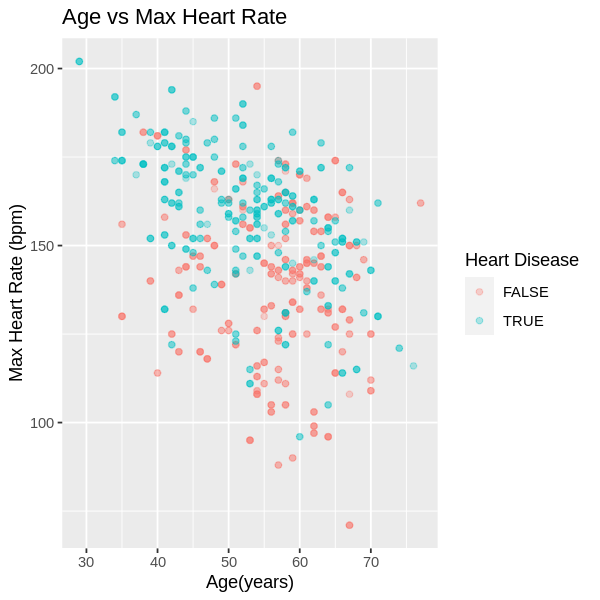

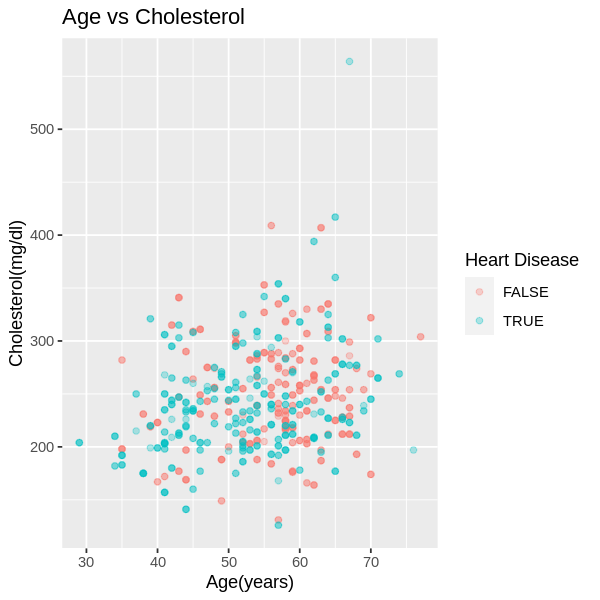

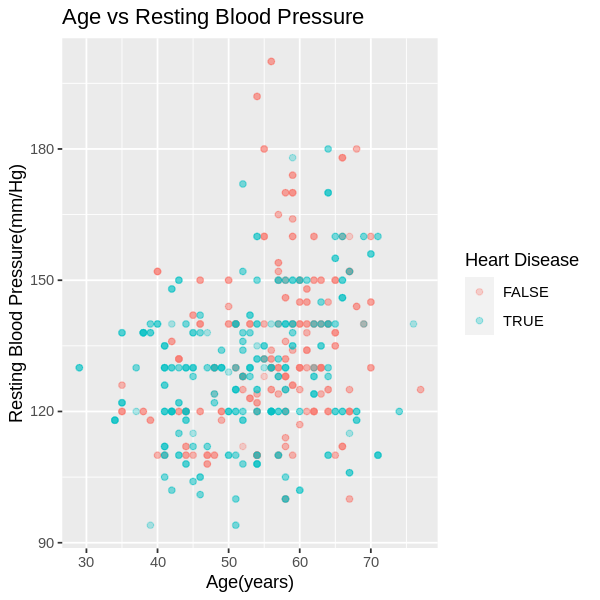

In [78]:
age_thalach_plot <- ggplot (heart_training, aes (x = age, y = thalach, color = heart_disease)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Age(years)", y = "Max Heart Rate (bpm)", color = "Heart Disease", title = "Age vs Max Heart Rate")


age_chol_plot<- ggplot(heart_training, aes(x = age,y = chol, colour = heart_disease))+
                        geom_point(alpha=0.3)+
                        labs(x = "Age(years)" ,y = "Cholesterol(mg/dl)", colour="Heart Disease", title = "Age vs Cholesterol")

age_trestbps_plot <- ggplot(heart_training,aes(x = age, y = trestbps, colour = heart_disease))+
                        geom_point(alpha=0.3)+
                        labs(x = "Age(years)", y = "Resting Blood Pressure(mm/Hg)", colour = "Heart Disease", title = "Age vs Resting Blood Pressure")

age_thalach_plot
age_chol_plot
age_trestbps_plot

## Methods
For our Heart Disease data set, we are going to use the method of K-nearest neighbors classification. Essentially, we are going to use predictor variables chol (amount of cholesterol), thalach (max heart rate), age, sex and tresbps (resting blood pressure) to predict the diagnosis class of heart disease, which can be categorized into 0 (no heart disease) or 1 (heart disease). Therefore, the column names we will incorporate are chol, thalach, age, sex, trestbps and target. We chose to only use four predictor variables because we think that there are more than two factors that contribute to the diagnosis of heart disease. Since there are multivariables, we can avoid a 4D graph by using the facet_grid function to create a plot that has multiple subplots arranged in a grid.

## Expected outcomes and significance


What do you expect to find?

We expect to identify the most relevant features that contribute to the presence or absence of heart disease. We also look for patterns and correlations within the data. For example, how the increase or decrease of a variable can alter the chance of heart disease.

What impact could such findings have?

Understanding the factors that contribute to heart disease can inform public health initiatives.Furthermore, discoveries from this dataset can enhance healthcare by improving diagnostic tools and predictive models for heart disease, potentially leading to early detection and treatment. These finding can also have a preventive effect; people with certain values or relationships with our variables can know beforehand to be extra careful with their health.

What future questions could this lead to?

In the case of our model, we can ask ourselves: "Are there additional attributes that should be considered, or are there redundant variables that can be eliminated to improve model performance?". But in a more general sense, this can lead to future questions of how to prevent certain cases of our variables, what kind of measures can be taken to minimize potential damages, etc.

